# Preparing Data

In [ ]:
import pandas as pd
data = pd.read_csv('news.csv')

data.drop('Unnamed: 0', inplace=True, axis=1)
data.dropna(inplace=True)

label_trans = lambda i: 0 if i == 'FAKE' else 1

data.label = data.label.apply(label_trans)
y = data['label']

raw_text = data.text + data.title

raw_text

# Stemming

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
raw_text = [[ps.stem(word) for word in sentence.split(" ")] for sentence in raw_text]

raw_text

# Tokenization and Stop words and punctuation removal

In [ ]:

from string import punctuation
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

def tokenize_and_stop_word_remove(text) :
    tokenized = [nltk.word_tokenize(str(token)) for token in text]
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.append("“")
    stop_words.append("”")
    stop_words.append("’")
    stop_words.append("‘")
    stop_words.append("—")
    new_list = [[token.lower() for token in tlist if token not in punctuation 
                 and token.lower() not in stop_words] for tlist in tokenized]
    return new_list


filtered_sentence = tokenize_and_stop_word_remove(raw_text)

filtered_sentence

# Feature Extraction

In [ ]:
import numpy as np
from gensim.models import Word2Vec

word_model = Word2Vec(filtered_sentence, min_count = 1, 
                      window = 5, sg = 1)
word_vectors = np.zeros((len(data), 100))

def vectors_build(word_vectors, cleaned, word_model, length):
    for i in range(0, length):
        word_vectors[i] = 0
        for word in cleaned[i]:
            word_vectors[i] += word_model.wv[word]
    return word_vectors


word_vectors = vectors_build(word_vectors, filtered_sentence, word_model, len(data))

word_vectors

# Model Training

In [9]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")




X_train, X_test, Y_train, Y_test = train_test_split(word_vectors, y, test_size=0.3 , shuffle= True, random_state=42)
model = LogisticRegression(C=0.01, penalty='l1', solver='liblinear').fit(X_train, Y_train)
y_pred = model.predict(X_test)

print("Accuracy : ",accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred, target_names=['Fake', 'Real']))




Accuracy :  0.9331930562861652
              precision    recall  f1-score   support

        Fake       0.93      0.94      0.93       968
        Real       0.93      0.93      0.93       933

    accuracy                           0.93      1901
   macro avg       0.93      0.93      0.93      1901
weighted avg       0.93      0.93      0.93      1901



# Hyperparameter Tuning

In [15]:
from sklearn.model_selection import GridSearchCV
grid_params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                   'penalty':  ['none', 'l1', 'l2', 'elasticnet'],
                   'C': [100, 10, 1.0, 0.1, 0.01]}
gs = GridSearchCV(LogisticRegression(), grid_params, verbose=1, cv=3, n_jobs=-1)
g_res = gs.fit(X_train, Y_train)
print(g_res.best_params_)
print(g_res.best_estimator_) 

Fitting 3 folds for each of 60 candidates, totalling 180 fits
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=0.01, penalty='l1', solver='liblinear')


# Ploting Values

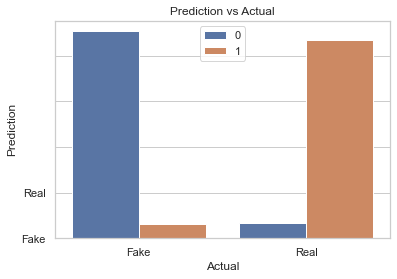

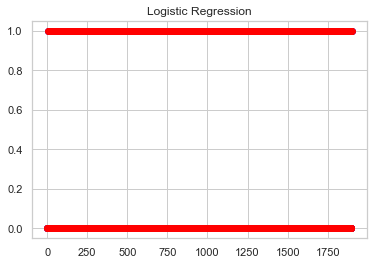

In [10]:
import seaborn as sns  
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
ax = sns.countplot(Y_test, hue=y_pred)
ax.set_title('Prediction vs Actual')
ax.set_xlabel('Actual')
ax.set_ylabel('Prediction')
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);
plt.show()

def plot_graph(y_test, y_pred, regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return

plot_graph(Y_test, y_pred, "Logistic Regression")

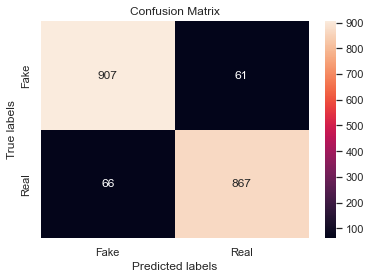

In [12]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=y_pred)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);